In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:53:04 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   49C    P2              78W / 260W |   6814MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [6]:
INPUT_PATH = '../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [7]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [8]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [9]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'PV', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'PV', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'PV', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'PV', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'PV'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['PRE', 'ART', 'PV', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection','reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['PRE', 'ART', 'PV', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['PRE', 'ART', 'PV', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['PRE', 'ART', 'PV', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'PV', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'PV', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'PV', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'PV', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    #Resized(keys=['PRE', 'ART', 'PV', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'PV'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'PV', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'PV', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'PV', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'PV', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'PV', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'PV'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'PV', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['PRE', 'ART', 'PV'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'PV']),
    Orientationd(keys=['PRE', 'ART', 'PV'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'PV'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear'), padding_mode=('reflection','reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'PV'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'PV'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [10]:
CACHE_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/monai_cache'


In [11]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [12]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [13]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.8182793259620667
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8437597751617432
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.1162647008895874


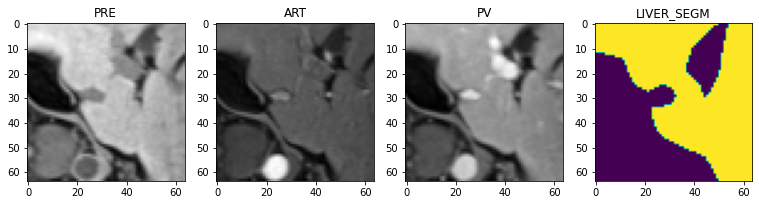

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: -0.003396419808268547
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.06311850249767303
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.0625663697719574


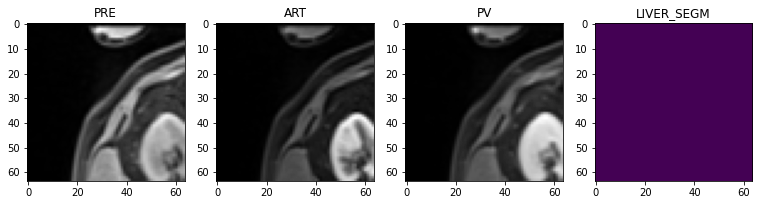

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.4933067858219147
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5525699853897095
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.7495604157447815


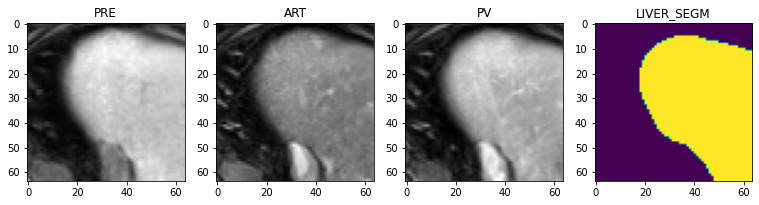

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7981448769569397
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8020264506340027
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.0503339767456055


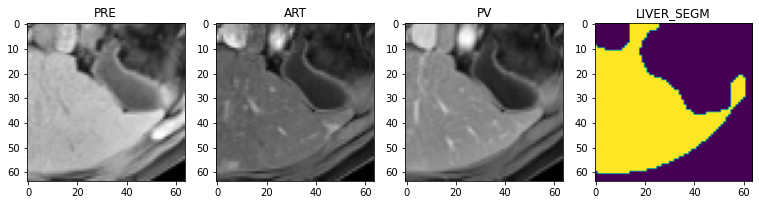

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5996395349502563
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8086550831794739
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.9730440378189087


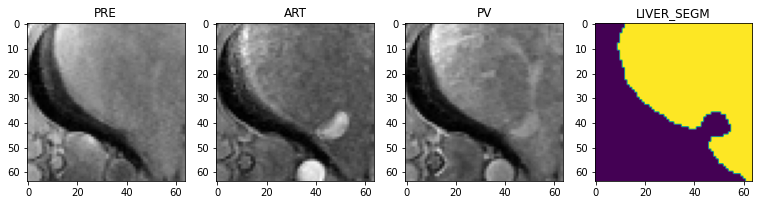

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: -0.08631367981433868
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: -0.07076868414878845
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: -0.09895897656679153


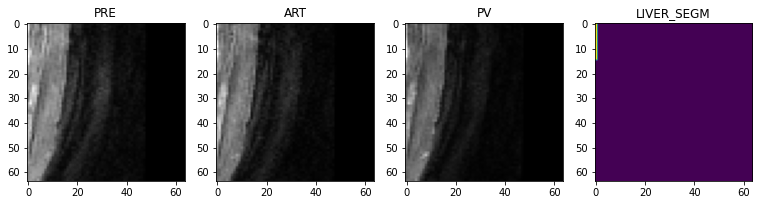

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7723699808120728
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.9823973178863525
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.0323221683502197


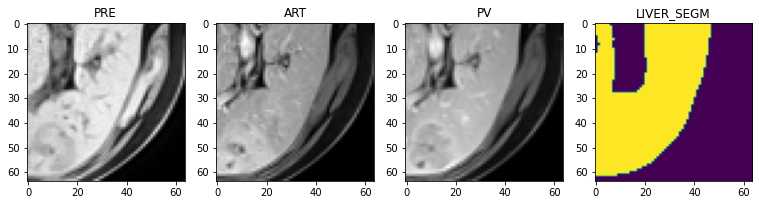

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 1.0826255083084106
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 1.4462846517562866
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.5606790781021118


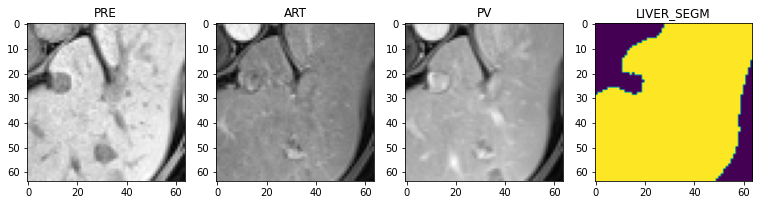

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6215242743492126
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.7430583834648132
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.6918801069259644


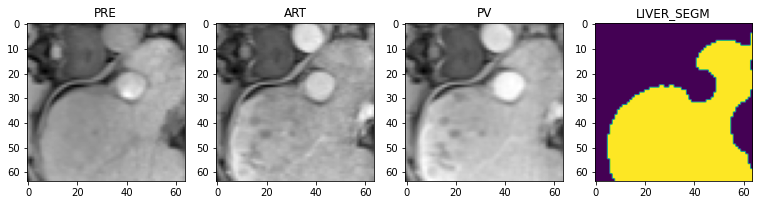

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5245450139045715
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.520275354385376
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.5104881525039673


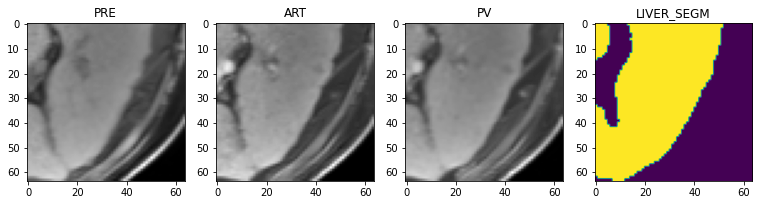

In [14]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)
print(check_data['PV'].shape)


num_display = 10
if check_data['PRE'].shape[0] < num_display:
    num_display = check_data['PRE'].shape[0]

for i in range(num_display):
    PRE, ART, PV , liver_label = (check_data['PRE'][i][0],check_data['ART'][i][0],check_data['PV'][i][0], check_data['SEGM'][i][0])


    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))



    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 4, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 4, 2)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 4 ,4)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [15]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._moPV = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=3, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._moPV(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        pre_images =  batch["PRE"]
        ART_images =  batch["ART"]
        pv_images =  batch["PV"]
        
        images = torch.cat((pre_images, ART_images, pv_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,3,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        pre_images =  batch["PRE"]
        ART_images =  batch["ART"]
        pv_images =  batch["PV"]

        
        images = torch.cat((pre_images, ART_images, pv_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._moPV.parameters(), lr=1e-4)
    
    

In [16]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,3,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       9,618
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,189,649
Trainable params: 1,189,649
Non-trainable params: 0
Total mult-adds (G): 1.70
Input size (MB): 1.57
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [17]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/'

In [18]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [19]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=0759-val_loss=0.06.ckpt')

In [20]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_moPV): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        (

In [21]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        if keep:
            dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
        else:
                
            # Calculate Dice on the raw output
            dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            
            
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            art_images =  test_data["ART"].to(device)
            pv_images =  test_data["PV"].to(device)

            x = torch.cat((pre_images, art_images, pv_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                art_img = art_images.detach().cpu()
                pv_img = pv_images.detach().cpu()



                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 5, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 2)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 3)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 4)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 5, 5)
                plt.title('PRED')
                plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['ART_meta_dict']['affine'][0].numpy()
                original_affine = test_data['ART_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['ART_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['ART_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [22]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV'

0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 165 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 165 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 166 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 165 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 165 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 166 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning

0.9679586887359619
3.037600274903435
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 9 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 10 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 11 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: th

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 9 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 10 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 11 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the predic

0.9693382382392883
1.169721714394392
inf
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


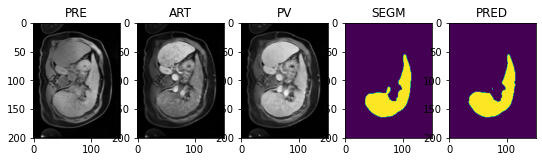

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100998852_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 50 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9760767221450806
4.332655210065851
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 47 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9773013591766357
1.421526935974667
inf
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


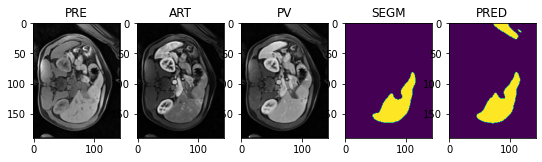

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/12370686_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9602296352386475
7.930923146989293
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9725741147994995
1.1567330591389655
inf
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


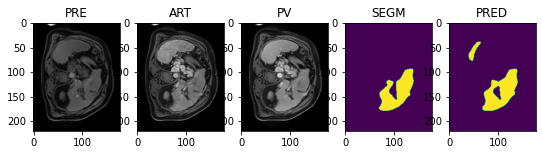

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104184251_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 220 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9553828835487366
23.73273508138311
inf
0.9678089618682861
1.6192463356004887
inf
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


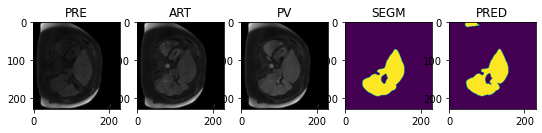

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100353838_T1_ART_segm.nii.gz
0.9497542977333069
18.991849422463815
inf
0.9638084173202515
1.3870862017664625
inf
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


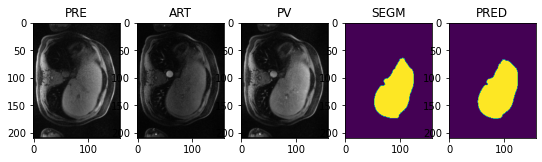

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11655071_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 160 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWar

0.9606665372848511
1.2456453484145784
inf
0.9606665372848511
1.2456453484145784
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


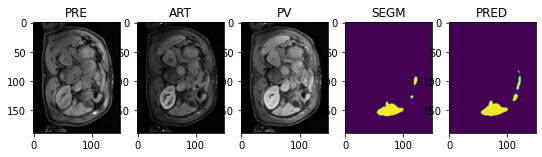

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105258820_T1_ART_segm.nii.gz
0.9703915119171143
1.4903967153985411
inf
0.9704002141952515
1.4903967153985411
inf
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


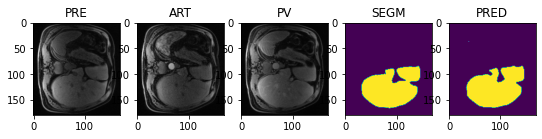

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/10782833_T1_ART_segm.nii.gz
0.9827325344085693
1.0237253673768194
inf
0.9827502369880676
1.0233530454884971
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


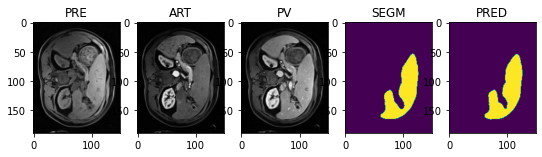

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105047582_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

0.9640709161758423
1.4032272431160762
inf
0.9640747308731079
1.4032272431160762
inf
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


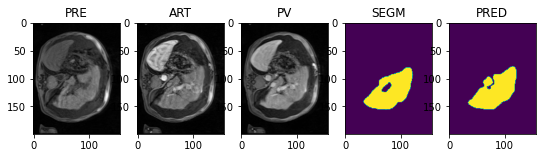

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100559269_T1_ART_segm.nii.gz
0.8882049918174744
12.799373411174944
inf
0.9232951402664185
3.570149444277919
inf
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


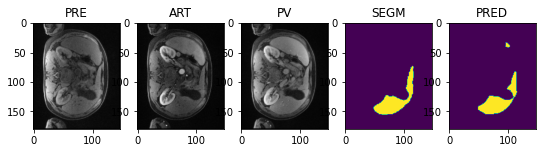

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11157922_T1_ART_segm.nii.gz
0.9722455739974976
3.215693939262445
inf
0.9723769426345825
3.189892168168495
inf
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


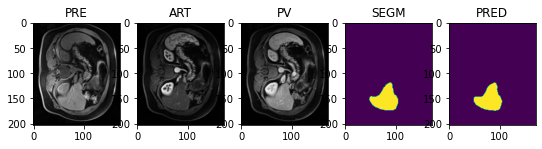

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E103977998_T1_ART_segm.nii.gz
0.9662023186683655
2.051115423121078
inf
0.9662023186683655
2.051115423121078
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


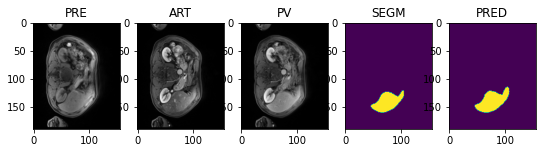

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106605970_T1_ART_segm.nii.gz
0.9452226161956787
10.098253459002612
inf
0.9510754346847534
4.619643855172594
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


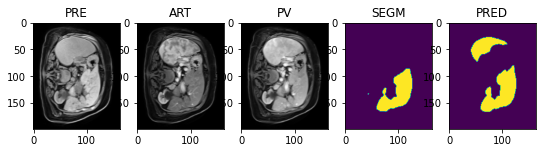

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101166449_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 78 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9376471042633057
46.786282924556424
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 76 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 78 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9638946652412415
2.6486817300199874
inf
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


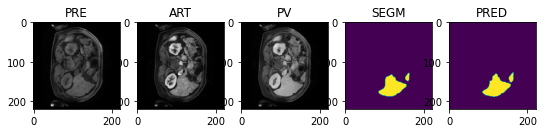

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101693803_T1_ART_segm.nii.gz
0.9728865623474121
3.7982639237758873
inf
0.9738140106201172
1.1962672047396532
inf
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


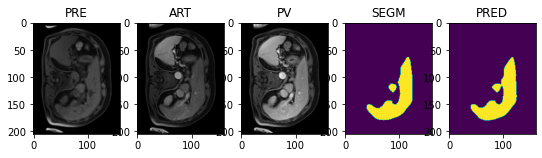

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100488381_T1_ART_segm.nii.gz
0.951262354850769
5.0755361757836726
inf
0.9513165950775146
3.6380361757836726
inf
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


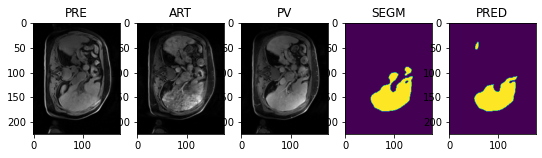

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101446184_T1_ART_segm.nii.gz
0.9364646077156067
7.983847153685486
inf
0.9401458501815796
1.7814802748556335
inf
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


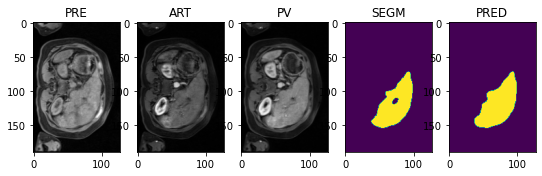

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/12132879_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 84 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarnin

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 84 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the g

0.9696365594863892
1.1433631589472635
inf
0.9696365594863892
1.1433631589472635
inf
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


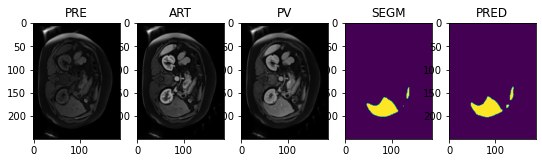

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100207522_T1_ART_segm.nii.gz
0.9506670236587524
10.84968397999387
inf
0.9720283150672913
1.6626719532041982
inf
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


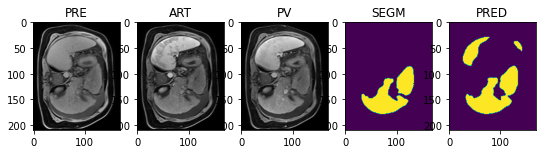

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104350920_T1_ART_segm.nii.gz
0.961639940738678
7.986948219178588
inf
0.9663702249526978
1.7213116708358962
0.42281651819739724
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


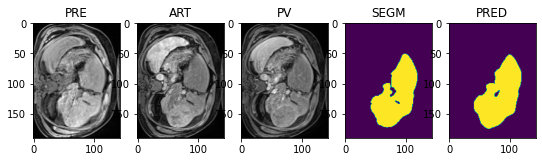

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E103442524_T1_ART_segm.nii.gz
0.9554471969604492
15.445191643572281
inf
0.9736018776893616
1.5901740237877822
inf
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


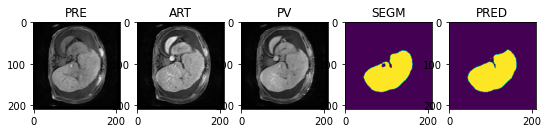

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100354995_T1_ART_segm.nii.gz
0.9700322151184082
4.743841350361198
inf
0.9707779884338379
1.5306503955873265
inf
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


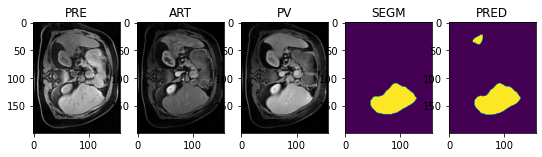

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/12169194_T1_ART_segm.nii.gz
0.9521721601486206
4.7499135469402205
inf
0.9554226398468018
1.3477998255416423
inf
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


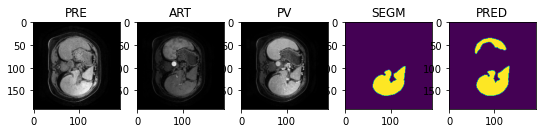

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/9464709_T1_ART_segm.nii.gz
0.977403998374939
3.462380604498429
inf
0.9783926606178284
0.9778199379403842
inf
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


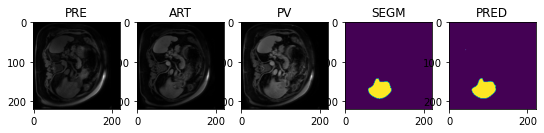

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E102885531_T1_ART_segm.nii.gz
0.9723825454711914
1.6708866860477016
inf
0.9728105068206787
1.5700644000945767
inf
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


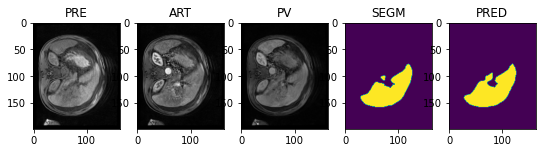

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106731917_T1_ART_segm.nii.gz
0.9568417072296143
42.34091151018066
inf
0.9713893532752991
3.9240711944729156
inf
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


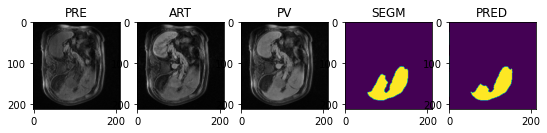

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105877173_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9663519859313965
4.594364626496699
inf
0.9672696590423584
1.4156516610677683
0.3445102751709429
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


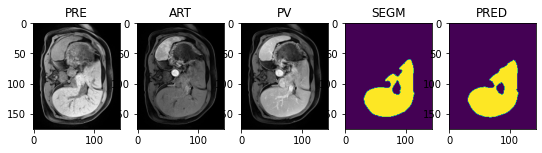

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106096969_T1_ART_segm.nii.gz
0.9651057720184326
1.6101324715337084
inf
0.9651812314987183
1.602536830107268
inf
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


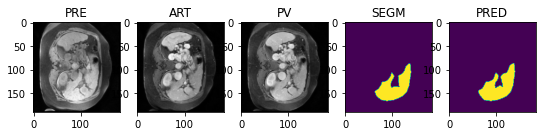

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11571840_T1_ART_segm.nii.gz
0.9703608155250549
1.528604831977543
inf
0.9703608155250549
1.528604831977543
inf
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


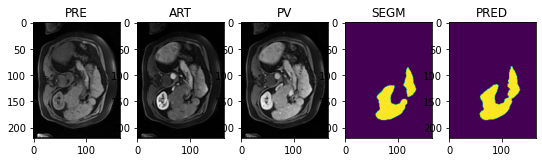

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101753253_T1_ART_segm.nii.gz
0.9786781072616577
0.98105812296211
inf
0.9786841869354248
0.98105812296211
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


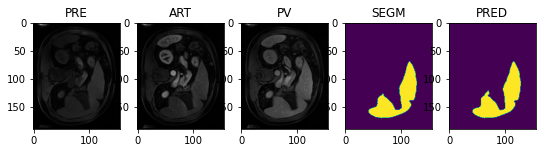

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E103922902_T1_ART_segm.nii.gz
0.9704372882843018
6.800711033865428
inf
0.9727368354797363
1.71801689205049
inf
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


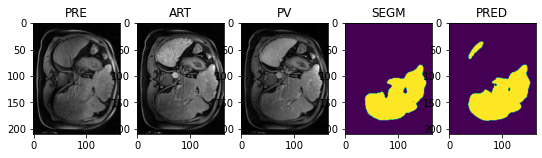

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101453378_T1_ART_segm.nii.gz
0.9493317604064941
28.58864383702603
inf
0.9589835405349731
2.030851915615003
inf
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


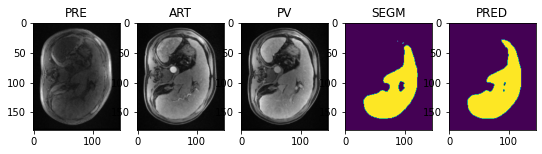

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11397044_T1_ART_segm.nii.gz
0.9676927924156189
1.5389869587110532
inf
0.9676951169967651
1.5389869587110532
inf
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


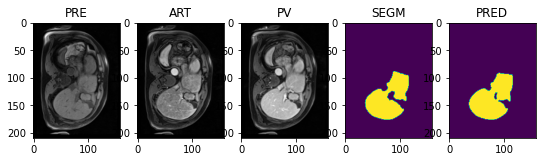

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/12922235_T1_ART_segm.nii.gz
0.9753211736679077
4.613059540900011
inf
0.9765317440032959
1.505994543535118
0.359690140049493
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


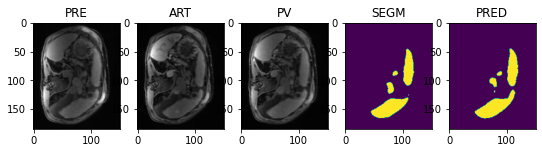

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/10939089_T1_ART_segm.nii.gz
0.953649640083313
2.7170754045701804
inf
0.954475462436676
1.9001317474783148
inf
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


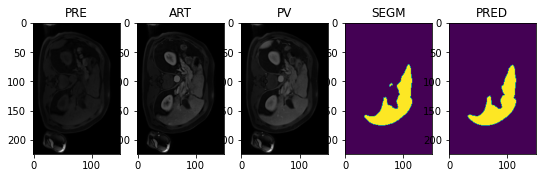

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/12957044_T1_ART_segm.nii.gz
0.9697657823562622
1.7310228042855829
inf
0.9697672128677368
1.7310228042855829
inf
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


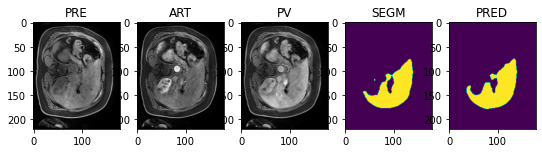

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107891018_T1_ART_segm.nii.gz
0.9766166806221008
3.285487201079175
inf
0.9767759442329407
1.2394872010791749
inf
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


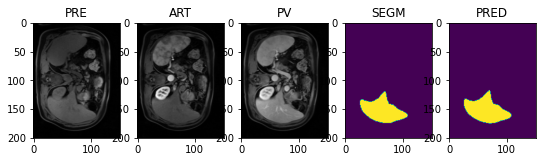

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104332583_T1_ART_segm.nii.gz
0.9731245040893555
1.0955011106570463
inf
0.9731322526931763
1.0955011106570463
0.32746234128359697
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


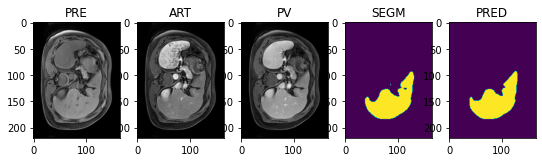

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101547088_T1_ART_segm.nii.gz
0.9726028442382812
3.625851971009104
0.5436981379789999
0.9728214740753174
1.530197827501851
0.34141693742141055
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


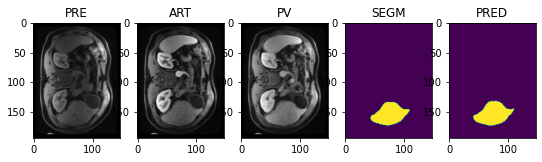

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11524268_T1_ART_segm.nii.gz
0.9743316173553467
2.001490024487813
inf
0.974810779094696
1.2186091519208297
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


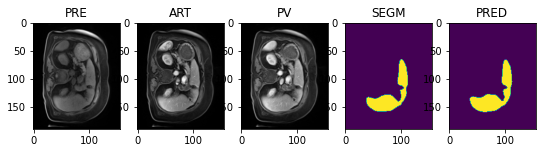

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106458466_T1_ART_segm.nii.gz
0.9501982927322388
2.4469241203871612
inf
0.9505437016487122
2.3975628662158597
inf
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


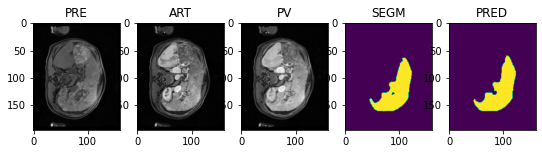

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107235152_T1_ART_segm.nii.gz
0.9596688151359558
8.165389927842737
inf
0.9641149044036865
1.939960826981228
0.5109380341324897
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


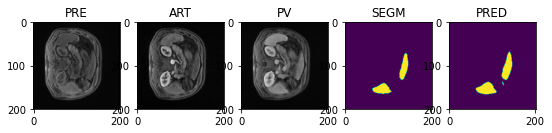

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105198762_T1_ART_segm.nii.gz
0.9516875743865967
4.481875314367158
inf
0.9516875743865967
4.481875314367158
inf
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


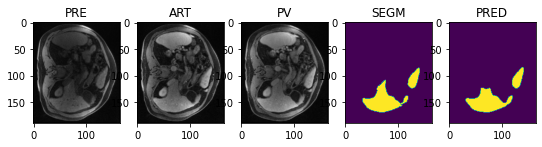

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11148247_T1_ART_segm.nii.gz
0.9679490923881531
1.8431675650635393
inf
0.9679588079452515
1.8406034624994367
0.4371242592468952
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


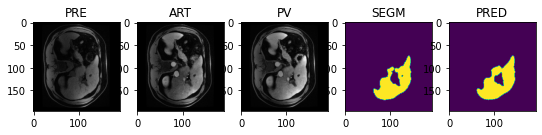

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106751045_T1_ART_segm.nii.gz
0.9598193764686584
2.2172635880177034
inf
0.9601577520370483
2.1554220269083655
inf
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


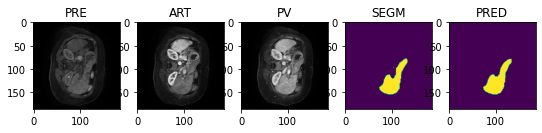

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/9648994_T1_ART_segm.nii.gz
0.9696819186210632
1.3840454564951434
0.3672745627917079
0.9696819186210632
1.3840454564951434
0.3672745627917079
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


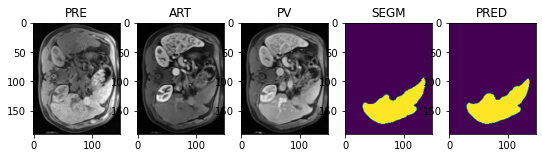

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E102928841_T1_ART_segm.nii.gz
0.9742404222488403
1.1044668337332522
0.3080449951807626
0.9742404222488403
1.1044668337332522
0.3080449951807626
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


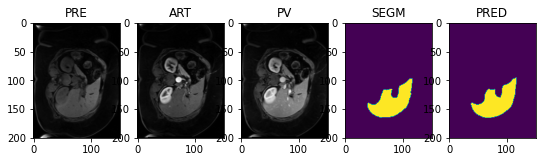

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105426183_T1_ART_segm.nii.gz
0.9665095806121826
13.442027522355758
inf
0.9719810485839844
1.402942817052704
inf
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


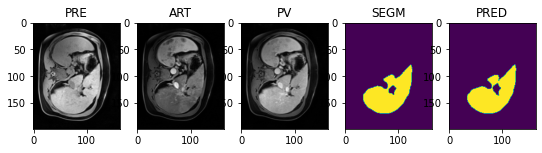

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100142484_T1_ART_segm.nii.gz
0.9721270799636841
1.871997432580984
inf
0.9721270799636841
1.871997432580984
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


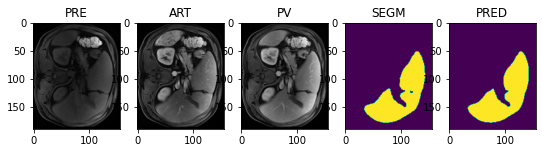

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105829099_T1_ART_segm.nii.gz
0.944108784198761
5.77572172100421
inf
0.9453401565551758
3.098853112810903
inf
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


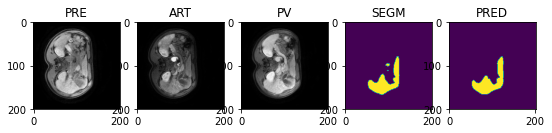

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/9586289_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 143 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9250105619430542
10.524473089824198
inf
0.9264963865280151
2.700230806237089
0.6924464135457314
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


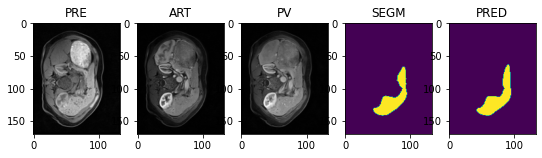

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107156072_T1_ART_segm.nii.gz
0.9655041694641113
3.60220483393364
inf
0.9661722183227539
1.2439248513652406
inf
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


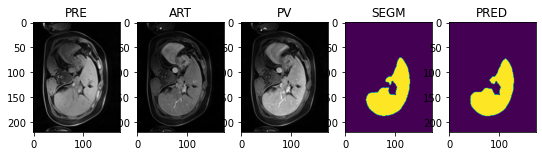

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104998309_T1_ART_segm.nii.gz
0.9658690690994263
2.896676634449815
inf
0.9660549163818359
1.3829698836151025
inf
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


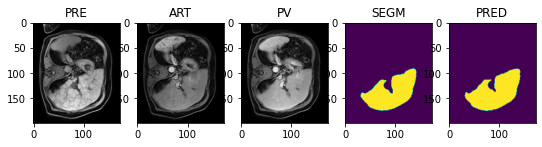

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105615985_T1_ART_segm.nii.gz
0.9769206047058105
1.0714652985106876
inf
0.9769206047058105
1.0714652985106876
inf
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


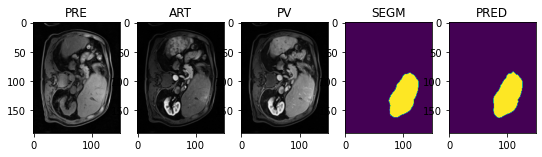

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/12916368_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 88 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWa

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 88 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: t

0.9696123600006104
2.2244931134109804
inf
0.9697090983390808
1.6999232808168876
inf
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


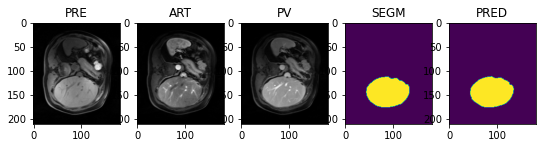

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E103814356_T1_ART_segm.nii.gz
0.965529203414917
3.085811181247922
inf
0.965530514717102
3.085811181247922
inf
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


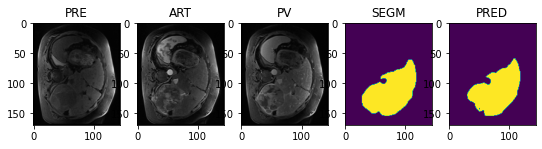

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11022925_T1_ART_segm.nii.gz
0.9449523687362671
44.98944330866258
inf
0.9643527865409851
1.5079830369548266
inf
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


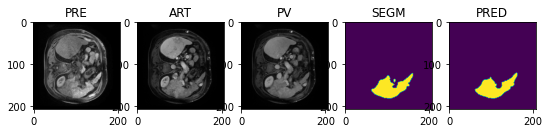

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106533478_T1_ART_segm.nii.gz
0.9693980813026428
1.7086288857213736
inf
0.9694059491157532
1.7086288857213736
inf
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


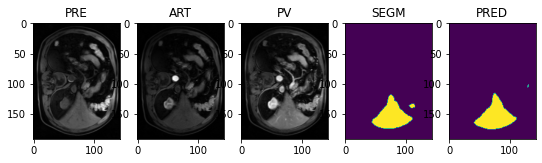

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106851724_T1_ART_segm.nii.gz
0.9564920663833618
3.352047515566377
inf
0.9566274285316467
2.0834845785926372
inf
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


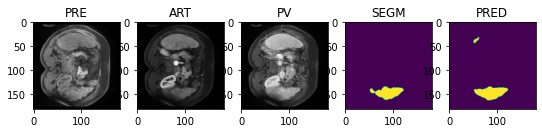

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E103511968_T1_ART_segm.nii.gz
0.9781036376953125
1.134932781076055
inf
0.9781036376953125
1.134932781076055
inf
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


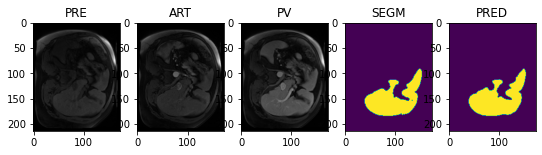

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107553107_T1_ART_segm.nii.gz
0.9311537742614746
36.68242247816841
inf
0.9624817967414856
1.640026571973768
0.3634221138789683
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


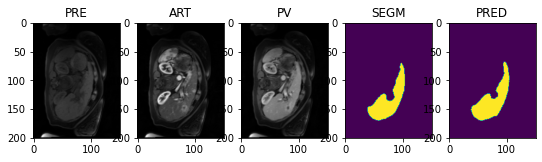

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100588448_T1_ART_segm.nii.gz
0.9676768779754639
1.9966014038849476
inf
0.967678427696228
1.9994783683902875
inf
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


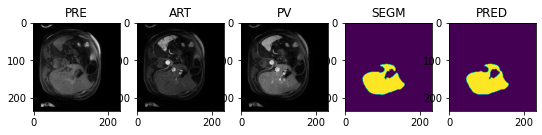

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104134228_T1_ART_segm.nii.gz
0.9221060872077942
54.35968209077175
inf
0.9680579900741577
1.1298560303931013
inf
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


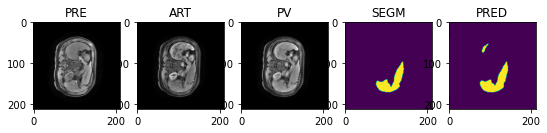

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101686218_T1_ART_segm.nii.gz
0.9391765594482422
3.763269263370054
inf
0.940014123916626
2.695714472733761
inf
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


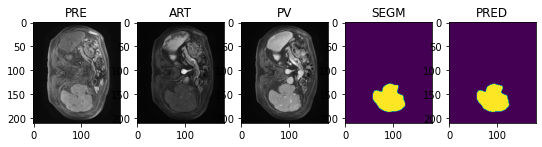

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E100967188_T1_ART_segm.nii.gz
0.9696058034896851
1.5458613341392247
inf
0.9696058034896851
1.5458613341392247
inf
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


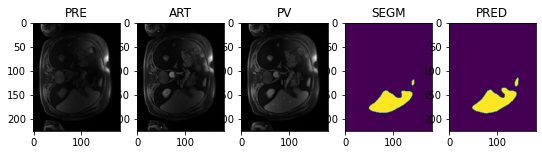

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107476766_T1_ART_segm.nii.gz
0.9193825721740723
41.4000925234098
inf
0.9552544951438904
1.2888757443790084
inf
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


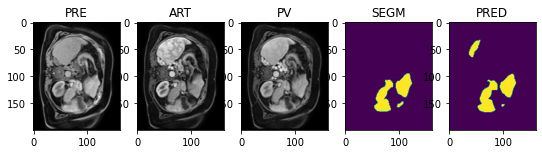

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104250009_T1_ART_segm.nii.gz
0.9792618751525879
2.4491137608503153
inf
0.9795164465904236
1.1023800925086076
inf
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


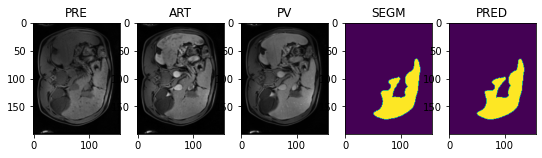

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105152299_T1_ART_segm.nii.gz
0.9525266885757446
14.193767261126998
inf
0.9613250494003296
1.2168096033999516
inf
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


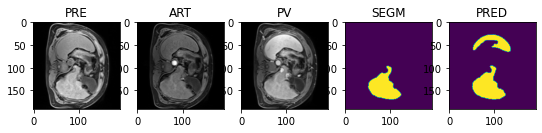

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/11308203_T1_ART_segm.nii.gz
0.9783910512924194
1.319120075692075
inf
0.9784174561500549
1.3146045705715008
inf
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


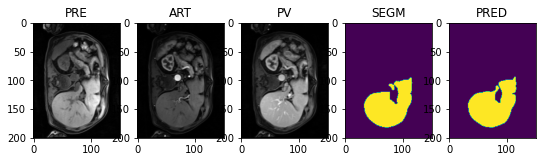

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107046127_T1_ART_segm.nii.gz
0.9644757509231567
1.421128773025421
inf
0.9644757509231567
1.421128773025421
inf
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


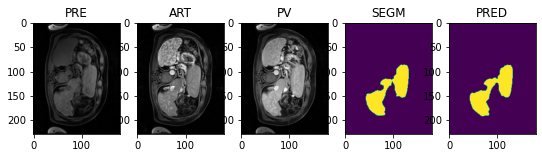

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/13106408_T1_ART_segm.nii.gz
0.9766901731491089
1.056642012981769
inf
0.9766937494277954
1.056642012981769
inf
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


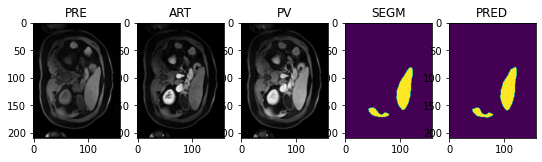

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E102486953_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWar

0.9417768716812134
8.305078227577445
inf
0.9669243693351746
1.8479399110552848
0.4093458868368845
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


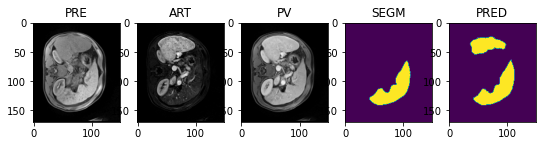

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101055640_T1_ART_segm.nii.gz
0.9714944958686829
4.945909202445268
inf
0.9714944958686829
4.945909202445268
inf
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


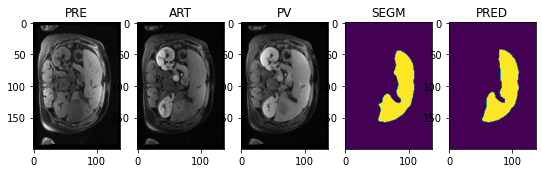

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/10807315_T1_ART_segm.nii.gz
0.9795730113983154
3.6035998041634123
inf
0.9810726642608643
1.3304135436706008
0.28190434752200433
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


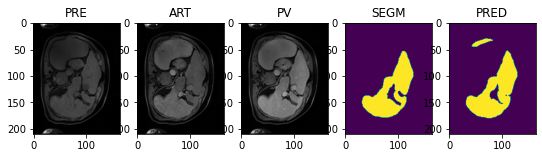

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/13170972_T1_ART_segm.nii.gz
0.952373743057251
3.374302708097012
inf
0.9523792266845703
3.374302708097012
inf
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


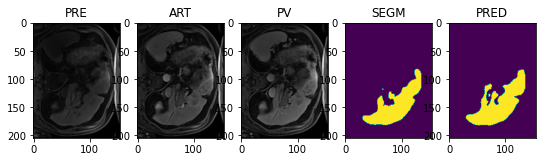

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104594843_T1_ART_segm.nii.gz
0.9678212404251099
5.8351204977158115
inf
0.9735252857208252
1.4242428877316642
inf
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


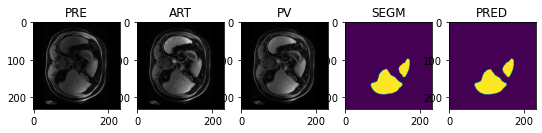

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104034609_T1_ART_segm.nii.gz
0.9713136553764343
7.1839863851885575
inf
0.9803309440612793
0.9545335488993318
0.2682402880405804
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


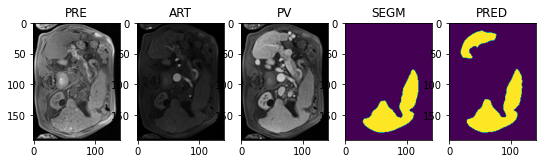

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107774979_T1_ART_segm.nii.gz
0.9667752981185913
1.474054324013058
inf
0.9667819142341614
1.474054324013058
0.33682336446299305
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


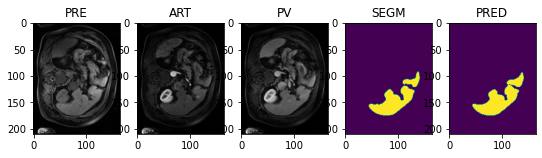

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104900599_T1_ART_segm.nii.gz
0.9771263003349304
1.3336652078063334
inf
0.977167546749115
1.3290800549679056
inf
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


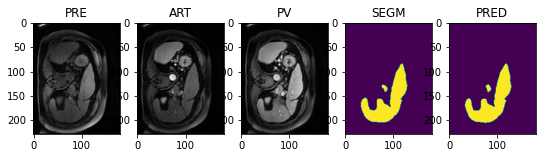

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E104657225_T1_ART_segm.nii.gz
0.964189887046814
8.461115212517829
inf
0.9686206579208374
1.6120226225450753
inf
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


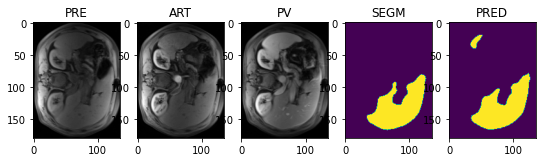

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105599954_T1_ART_segm.nii.gz
0.954898476600647
6.478018843057496
inf
0.954898476600647
6.478018843057496
inf
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


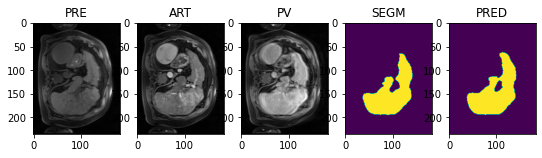

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E103570649_T1_ART_segm.nii.gz
0.9587308168411255
6.452306337843966
inf
0.9656965136528015
2.0243323034605654
inf
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


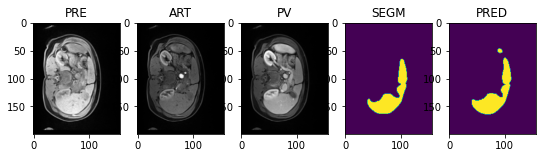

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E105504009_T1_ART_segm.nii.gz
0.9646013975143433
6.7221435758536465
inf
0.9728039503097534
1.4143729191133207
0.3879507700641697
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


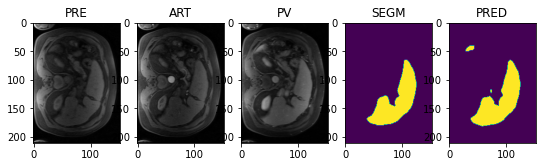

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E103831361_T1_ART_segm.nii.gz
0.9563974738121033
46.73289881571179
inf
0.9735095500946045
2.0728947775228432
inf
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


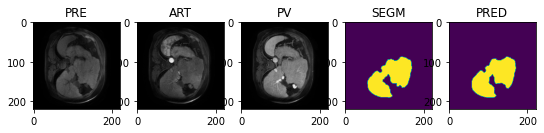

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/10843891_T1_ART_segm.nii.gz
0.9623086452484131
1.6041024407513333
inf
0.9623094797134399
1.6041024407513333
inf
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


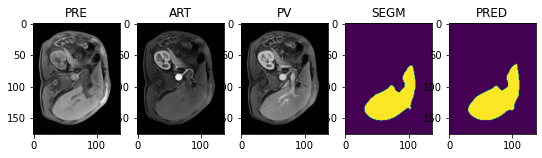

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E101762106_T1_ART_segm.nii.gz
0.9640694260597229
3.8475482616629866
inf
0.9646603465080261
1.5757957479829885
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


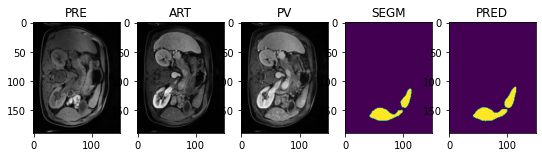

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/12543786_T1_ART_segm.nii.gz
0.9511958956718445
2.109502345482509
inf
0.9515596628189087
2.0737116722959814
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


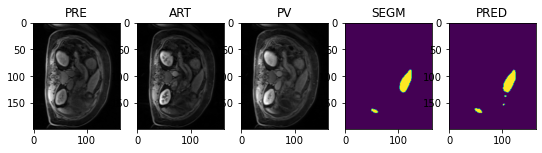

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E107077373_T1_ART_segm.nii.gz
0.971626877784729
1.2315259761306314
inf
0.9716460704803467
1.2297615591498277
inf
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


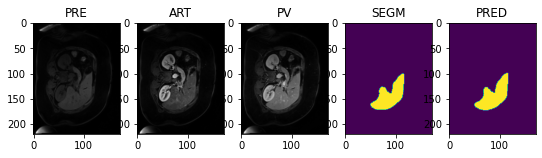

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-PV/E106501028_T1_ART_segm.nii.gz
[0.9679586887359619, 0.9760767221450806, 0.9602296352386475, 0.9553828835487366, 0.9497542977333069, 0.9606665372848511, 0.9703915119171143, 0.9827325344085693, 0.9640709161758423, 0.8882049918174744, 0.9722455739974976, 0.9662023186683655, 0.9452226161956787, 0.9376471042633057, 0.9728865623474121, 0.951262354850769, 0.9364646077156067, 0.9696365594863892, 0.9506670236587524, 0.961639940738678, 0.9554471969604492, 0.9700322151184082, 0.9521721601486206, 0.977403998374939, 0.9723825454711914, 0.9568417072296143, 0.9663519859313965, 0.9651057720184326, 0.9703608155250549, 0.9786781072616577, 0.9704372882843018, 0.9493317604064941, 0.9676927924156189, 0.9753211736679077, 0.953649640083313, 0.9697657823562622, 0.9766166806221008, 0.9731245040893555, 0.9726028442382812, 0.9743316173553467, 0.9501982927322388, 0.9596688151359558, 0.9516875743865967, 0.967949092388

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.967959   0.969338   3.037600   1.169722       0.012444   
1  0.976077   0.977301   4.332655   1.421527       0.004867   
2  0.960230   0.972574   7.930923   1.156733       0.008729   
3  0.955383   0.967809  23.732735   1.619246       0.013254   
4  0.949754   0.963808  18.991849   1.387086       0.005572   

                                AUTOMATED-LIVER-SEGM      EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-PV  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-PV  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-PV  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-PV  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-PV

In [46]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '3mpMRI-PRE-ART-PV'
df_test_results.head()

In [48]:
df_test_results.to_csv('../Results/Results-3mpMRI-Net_PRE-ART-PV.csv')